In [87]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.gridspec as gs
import matplotlib.cm as cm


In [2]:
from dask.distributed import Client

client = Client(memory_limit='250gb',n_workers=48)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33019/status,
Dashboard: /proxy/33019/status,Workers: 48
Total threads: 48,Total memory: 10.91 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46327,Workers: 48
Dashboard: /proxy/33019/status,Total threads: 48
Started: Just now,Total memory: 10.91 TiB
Comm: tcp://127.0.0.1:40933,Total threads: 1
Dashboard: /proxy/46151/status,Memory: 232.83 GiB
Nanny: tcp://127.0.0.1:36579,


In [3]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580

In [31]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/Ant_cross_slope_heat_terms_offline_1000m_1958-01.nc')

# CSHT in z space
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/Ant_cross_slope_heat_terms_offline_1000m_1958-01.nc')

unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0)
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)


In [37]:
%%time
#age from the end of iaf  yle 2, to appemnd to the cycle 3
age_transect_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','age_global' , session,n=-1)\
.isel(yt_ocean=slice(0,ylength)).isel(time=-1)

age_transect_IC = age_transect_IC.sel(xt_ocean = CSHT_along.lon_along_contour,\
yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask

age_transect_IC.load()

#age 
age_transect= cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
age_transect = age_transect.sel(xt_ocean = CSHT_along.lon_along_contour,\
yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask


age_transect = age_transect  + age_transect_IC

#temp
temp_transect = cc.querying.getvar(iaf_cycle3,'temp' , session,\
                                        frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength)) -273.25
temp_transect = temp_transect.sel(xt_ocean = CSHT_along.lon_along_contour,\
yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask

#salinity
salt_transect= cc.querying.getvar(iaf_cycle3,'salt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
salt_transect = salt_transect.sel(xt_ocean = CSHT_along.lon_along_contour,\
yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask

age_transect.load()
temp_transect.load()
salt_transect.load()

sbins = np.arange(34,35, 0.01)
tbins = np.arange(-2, 3, 0.05)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects t

In [41]:
from gsw import sigma0
from gsw import SA_from_SP
sbins_mesh,tbins_mesh = np.meshgrid(sbins,tbins)
tbins_mesh  = np.where(tbins_mesh<=1.5,tbins_mesh,np.nan)
tbins_mesh  = np.where(tbins_mesh>=-2,tbins_mesh,np.nan)
sigma_forTS = sigma0(sbins_mesh,tbins_mesh)

In [42]:
#converting salinity to absolute
salt_depth_TS = ((salt_transect.mean('time')*0)+1) * salt_transect.mean('time').st_ocean
salt_lon_TS = ((salt_transect.mean('time')*0)+1) * salt_transect.mean('time').xt_ocean
salt_lat_TS = ((salt_transect.mean('time')*0)+1) * salt_transect.mean('time').yt_ocean

In [45]:
files_path = '/g/data/e14/qo9901/ASC_collab_CSHT_ds/'
file_extension = 'agemaskCDW_volav_corr'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


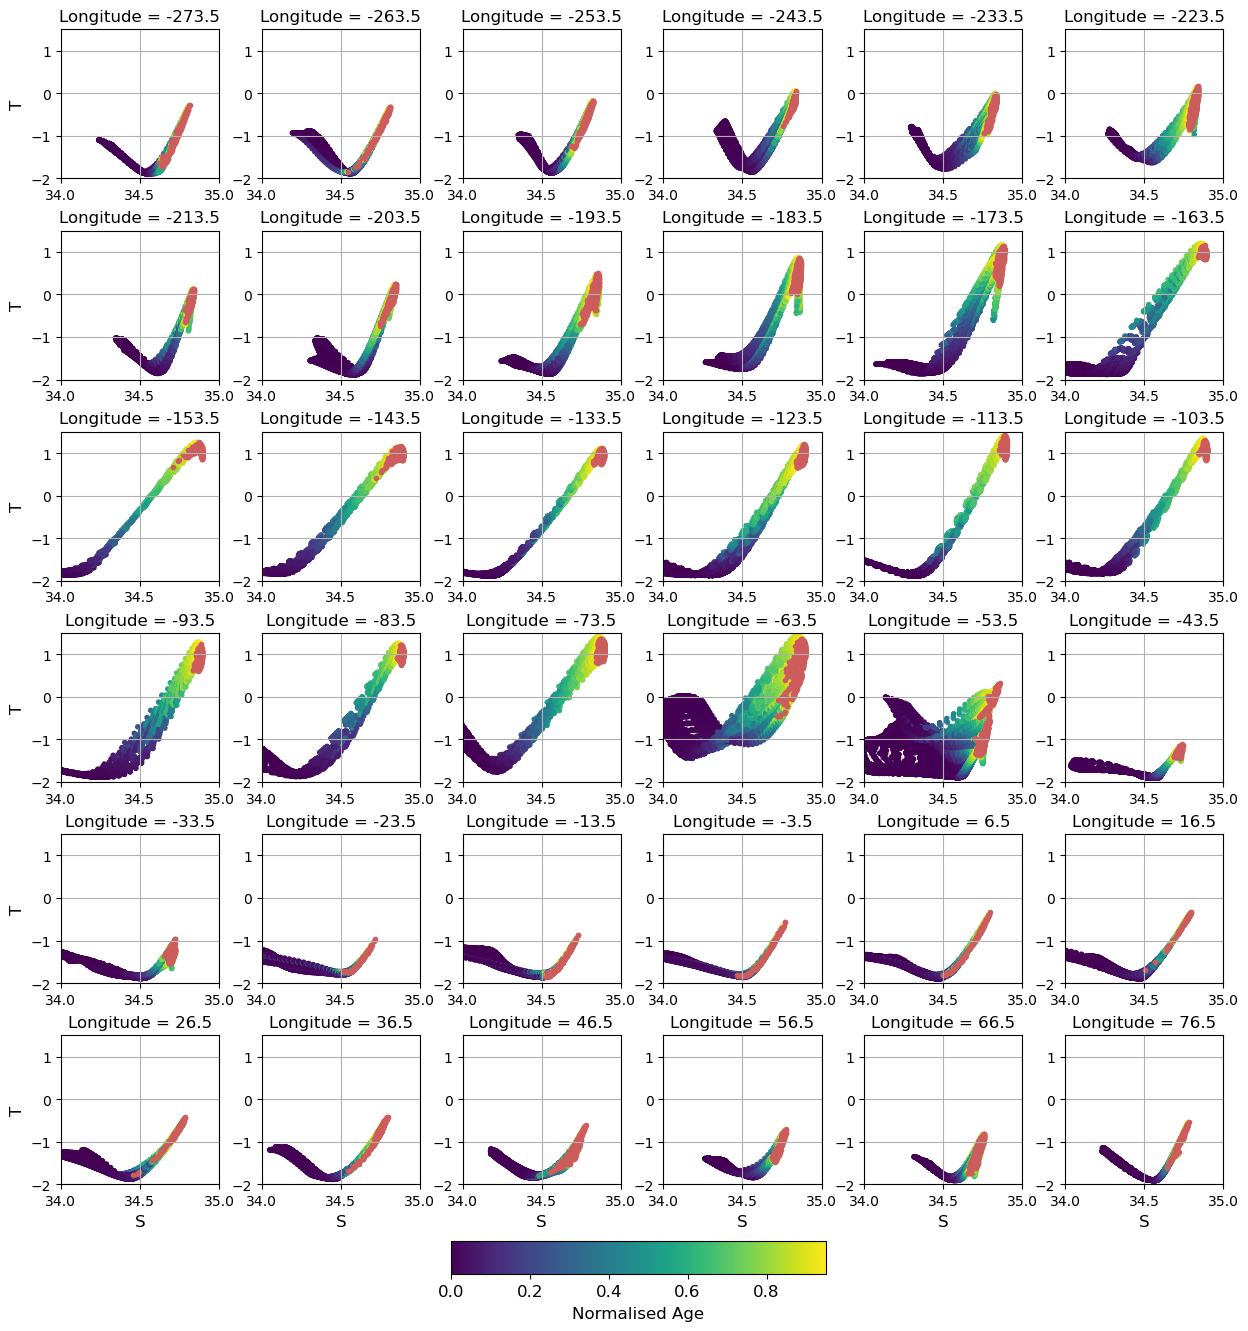

In [107]:
# %%time
fig = plt.figure(figsize=(15,15))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=6, ncols=6, figure=fig)
grid.update(hspace=0.35, wspace=0.27)  # Adjust vertical and horizontal spacing
percentage = np.zeros(ds.lon_bins.values.size)
for i in range(6):
    for k in range(6):
        j = i * 6 + k
        print(j)
        lon_min = ds.lon_bins.values[j]-5
        lon_max = ds.lon_bins.values[j]+5
    
        Absolute_salt_TS = SA_from_SP(salt_transect.where(salt_transect.xt_ocean>=lon_min)\
                                      .where(salt_transect.xt_ocean<lon_max).\
                                      mean('time'),salt_depth_TS,salt_lon_TS,salt_lat_TS)
        
        mean_temp_TS = temp_transect.where(temp_transect.xt_ocean>=lon_min)\
                                      .where(temp_transect.xt_ocean<lon_max).mean('time')
        #creating the normalized age in z for visualization
        age_transect_z_normalized = (age_transect.where(temp_transect.xt_ocean>=lon_min)\
                                      .where(temp_transect.xt_ocean<lon_max).mean('time')\
                                     /age_transect.where(temp_transect.xt_ocean>=lon_min)\
                                      .where(temp_transect.xt_ocean<lon_max).mean('time').max('st_ocean'))
        percentage[j] = age_transect_z_normalized.where(age_transect_z_normalized >= 0.95).count().values\
        /age_transect_z_normalized.count().values*100
        
        ax = fig.add_subplot(grid[i, k])
    
        TS  = ax.scatter(np.array(Absolute_salt_TS.where(age_transect_z_normalized < 0.95)).reshape([75*6002,1]),\
         np.array(mean_temp_TS.where(age_transect_z_normalized < 0.95)).reshape([75*6002,1]),\
         c=np.array(age_transect_z_normalized.where(age_transect_z_normalized < 0.95)).reshape([75*6002,1]),\
            marker='.')
        ax.scatter(np.array(Absolute_salt_TS.where(age_transect_z_normalized >= 0.95)).reshape([75*6002,1]),\
         np.array(mean_temp_TS.where(age_transect_z_normalized >= 0.95)).reshape([75*6002,1]),\
         c='indianred',marker='.')
        # sigma_surfs = ax.contour(sbins_mesh,tbins_mesh,sigma_forTS,\
        #                   levels=[27.1,27.2,27.3,27.4,27.5,27.6,27.7, 27.8,27.9,28],\
        #                   linewidth=0.5,colors='grey')
        if k == 0:
            ax.set_ylabel(r"T",fontsize=12); 
        if i == 5:
            ax.set_xlabel(r"S",fontsize=12)
        ax.set_xlim(34,35); plt.ylim(-2,1.5)
        ax.grid()
        # ax.set_xticks(ticks=[34,34.2,34.4,34.6,34.8])
        # ax.set_yticks(fontsize=16)
        # ax.clabel(sigma_surfs,levels=[27.2,27.4,27.6,27.7, 27.8,27.9,28],fontsize='x-large')
        ax.set_title('Longitude = '+str(ds.lon_bins.values[j]),fontsize=12)

# colorbar:
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=0, vmax = 0.95))

cax = fig.add_axes([0.385,0.05,0.25,0.022])
cbar = plt.colorbar(sm, cax=cax, orientation = 'horizontal', extend = 'neither')
cbar.set_label(r'Normalised Age', fontsize=12, labelpad=5)
cbar.ax.tick_params(labelsize=12)

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'
figure_path = figdir+'age_of_CDW.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')

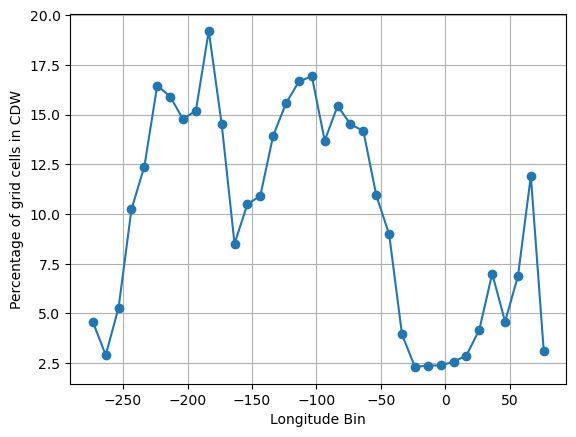

In [102]:
plt.plot(ds.lon_bins.values, percentage, '-o')
plt.ylabel('Percentage of grid cells in CDW')
plt.xlabel('Longitude Bin')
plt.grid()
figure_path = figdir+'percentage_of_CDW_cells.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [108]:
percentage_da = xr.DataArray(data = percentage, dims = ds.dims, coords = ds.coords)

In [110]:
ds = xr.Dataset()
ds['Perc_cells_in_CDW'] = percentage_da
ds.to_netcdf('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/percentage_of_CDW.nc')